# CloudDrift - Binning module

This repo contains 

In [1]:
import cmocean
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from clouddrift.binning import binned_statistics
from clouddrift.datasets import gdp6h

In [2]:
binned_statistics?

Signature:
binned_statistics(
    coords: numpy.ndarray | list[numpy.ndarray],
    data: numpy.ndarray | list[numpy.ndarray] | None = None,
    bins: int | list = 10,
    bins_range: list | None = None,
    dim_names: list[str] | None = None,
    output_names: list[str] | None = None,
    statistics: Union[str, list, Callable[[numpy.ndarray], float]] = 'count',
) -> xarray.core.dataset.Dataset
Docstring:
Perform N-dimensional binning and compute mean of values in each bin. The result is returned as an Xarray Dataset.

Parameters
----------
coords : array-like or list of array-like
    Array(s) of Lagrangian data coordinates to be binned. For 1D, provide a single array.
    For N-dimensions, provide a list of N arrays, each giving coordinates along one dimension.
data : array-like or list of array-like
    Data values associated with the Lagrangian coordinates in coords.
    Can be a single array or a list of arrays for multiple variables.
    Complex values are supported for the suppor

In [3]:
ds = gdp6h()
ds

<xarray.Dataset> Size: 2GB
Dimensions:                (traj: 27647, obs: 46535470)
Coordinates:
    id                     (traj) int64 221kB ...
    time                   (obs) datetime64[ns] 372MB ...
Dimensions without coordinates: traj, obs
Data variables: (12/49)
    BuoyTypeManufacturer   (traj) |S20 553kB ...
    BuoyTypeSensorArray    (traj) |S20 553kB ...
    CurrentProgram         (traj) float64 221kB ...
    DeployingCountry       (traj) |S20 553kB ...
    DeployingShip          (traj) |S20 553kB ...
    DeploymentComments     (traj) |S20 553kB ...
    ...                     ...
    start_lon              (traj) float32 111kB ...
    temp                   (obs) float32 186MB ...
    typebuoy               (traj) |S10 276kB ...
    typedeath              (traj) int8 28kB ...
    ve                     (obs) float32 186MB ...
    vn                     (obs) float32 186MB ...
Attributes: (12/18)
    Conventions:          CF-1.6
    acknowledgement:      Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    date_created:         2024-04-04T13:44:01.176967
    doi:                  10.25921/7ntx-z961
    ...                   ...
    publisher_name:       GDP Drifter DAC
    publisher_url:        https://www.aoml.noaa.gov/phod/gdp
    summary:              Global Drifter Program six-hourly data
    time_coverage_end:    2023-10-18:18:00:00Z
    time_coverage_start:  1979-02-15:00:00:00Z
    title:                Global Drifter Program drifting buoy collection

# Binned statistics

Note: the first time, we still need to download all the coordinates and velocity (takes ~1 min).

In [6]:
coords = [ds.lon.values, ds.lat.values]
variables = [ds.ve.values, ds.vn.values, ds.temp.values]

# Compute 3D binned averages
ds_global = binned_statistics(
    coords=coords,
    data=variables,
    bins=[180, 90],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=["mean", "min", "max"],
)

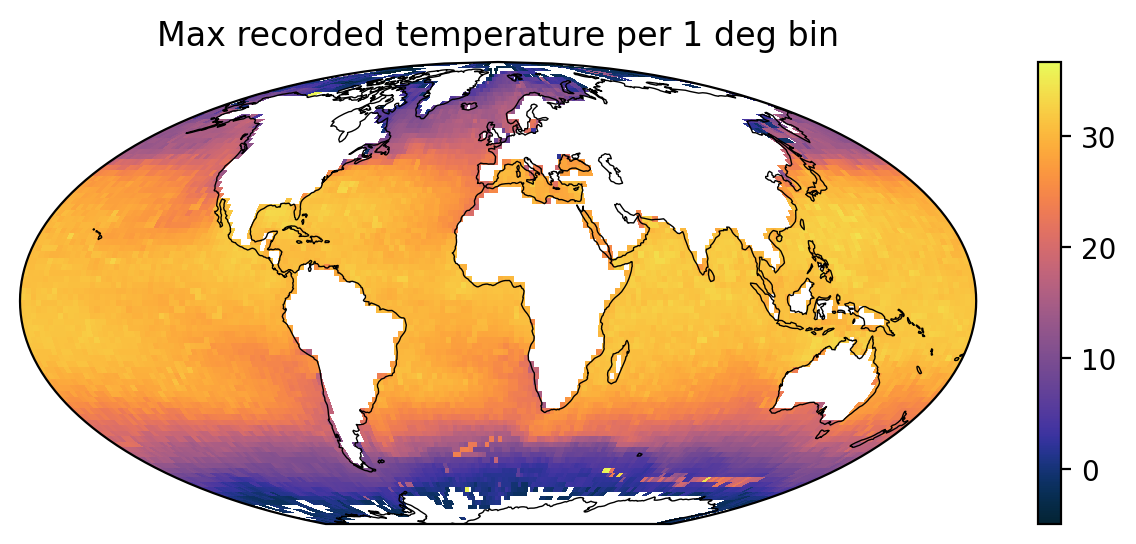

In [7]:
fig = plt.figure(figsize=(8, 3), dpi=200)
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.Mollweide()})

pcm = ax.pcolormesh(
    ds_global.lon,
    ds_global.lat,
    ds_global["temp_max"].values.T,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.thermal,
)


ax.set_title("Max recorded temperature per 1 deg bin")
ax.coastlines(linewidth=0.5)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.colorbar(pcm)

# Gulf of Mexico

Let's visualize for example, the maximum velocity recorded by the Global Drifter Program inside 0.25º bins in the Gulf of Mexico. For this, we can subset our dataset using `clouddrift.ragged.subset`, see (our website for more details)[https://clouddrift.org/_autosummary/clouddrift.ragged.subset.html#clouddrift.ragged.subset], or we can specify the `bins_range` directly into `binned_statistics`.

In [8]:
# Compute 3D binned averages
ds_binned = binned_statistics(
    coords=coords,
    data=variables,
    bins=[80, 52],
    bins_range=[[-98, -78], [18, 31]],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=["max"],
)

In [9]:
ds_binned

<xarray.Dataset> Size: 101kB
Dimensions:   (lon: 80, lat: 52)
Coordinates:
  * lon       (lon) float64 640B -97.88 -97.62 -97.38 ... -78.62 -78.38 -78.12
  * lat       (lat) float64 416B 18.12 18.38 18.62 18.88 ... 30.38 30.62 30.88
Data variables:
    ve_max    (lon, lat) float64 33kB -inf -inf -inf ... 0.7086 0.5948 0.8804
    vn_max    (lon, lat) float64 33kB -inf -inf -inf ... 0.7867 0.5692 0.5039
    temp_max  (lon, lat) float64 33kB -inf -inf -inf -inf ... 30.19 29.47 29.97

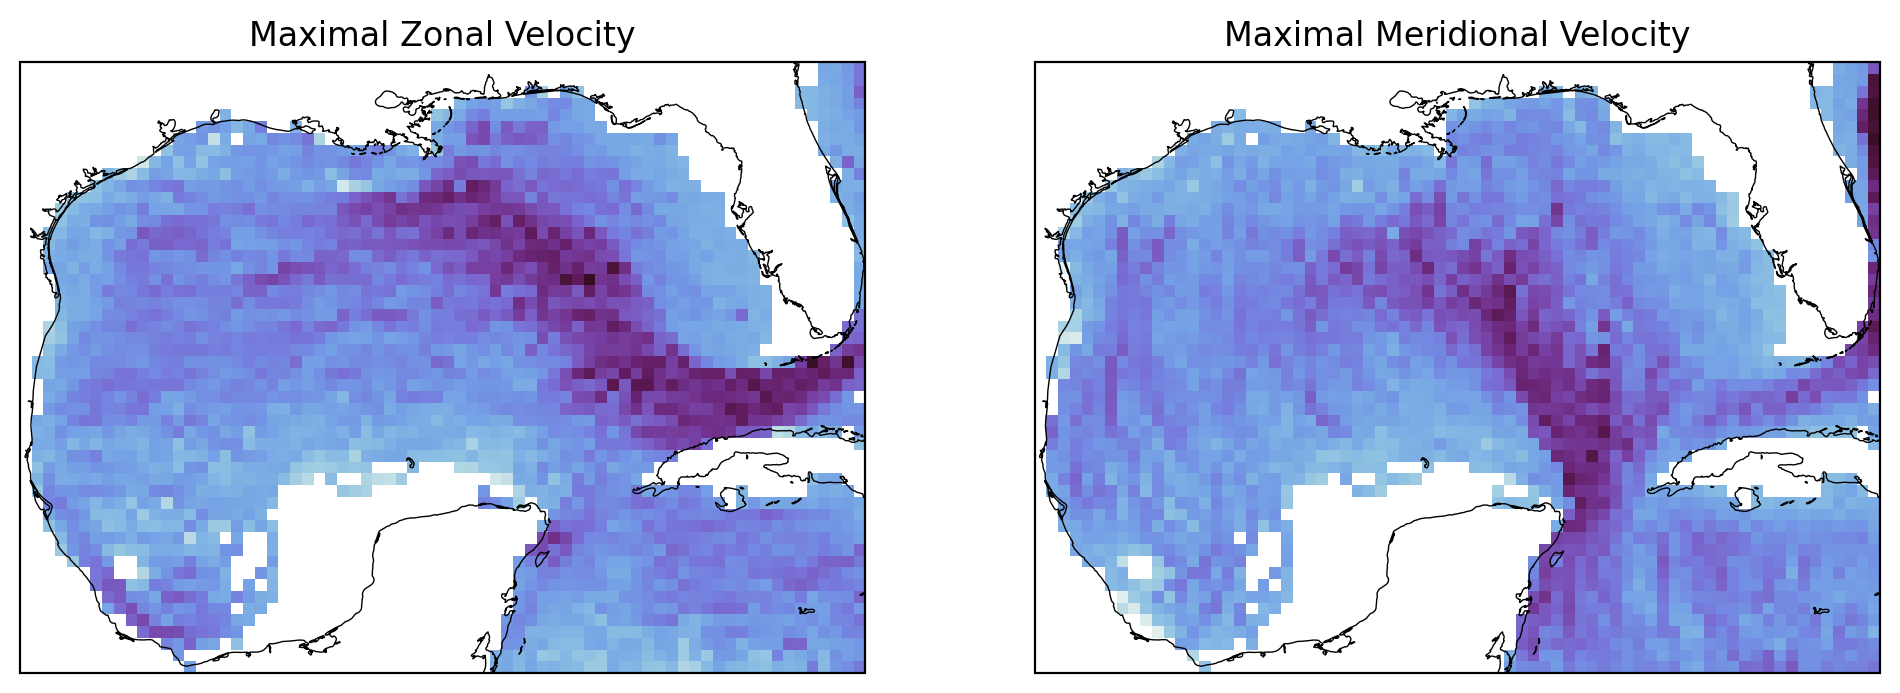

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi=200)
axes = fig.subplots(1, 2, subplot_kw={"projection": ccrs.PlateCarree()})

axes[0].pcolormesh(
    ds_binned.lon,
    ds_binned.lat,
    ds_binned["ve_max"].values.T,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.dense,
)

axes[1].pcolormesh(
    ds_binned.lon,
    ds_binned.lat,
    ds_binned["vn_max"].values.T,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.dense,
)

titles = ["Maximal Zonal Velocity", "Maximal Meridional Velocity"]
for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.coastlines(linewidth=0.5)
    ax.set_extent([-98, -80, 18, 31], crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")


As we saw previously, the statistics can be specified as a string. The supported values: 'count', 'sum', 'mean', 'median', 'std', 'min', 'max', (default: "count").

In [14]:
ds_binned_all = binned_statistics(
    coords=coords,
    data=variables,
    bins=[80, 52],
    bins_range=[[-98, -78], [18, 31]],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=["count", "sum", "mean", "median", "std", "min", "max"],
)

ds_binned_all

<xarray.Dataset> Size: 700kB
Dimensions:      (lon: 80, lat: 52)
Coordinates:
  * lon          (lon) float64 640B -97.88 -97.62 -97.38 ... -78.38 -78.12
  * lat          (lat) float64 416B 18.12 18.38 18.62 ... 30.38 30.62 30.88
Data variables: (12/21)
    ve_count     (lon, lat) int64 33kB 0 0 0 0 0 0 0 ... 346 362 320 374 231 183
    vn_count     (lon, lat) int64 33kB 0 0 0 0 0 0 0 ... 346 362 320 374 231 183
    temp_count   (lon, lat) int64 33kB 0 0 0 0 0 0 0 ... 341 353 316 353 219 178
    ve_sum       (lon, lat) float64 33kB 0.0 0.0 0.0 0.0 ... -25.67 -27.87 -14.1
    vn_sum       (lon, lat) float64 33kB 0.0 0.0 0.0 ... -36.83 -28.47 -22.67
    temp_sum     (lon, lat) float64 33kB 0.0 0.0 0.0 ... 5.589e+03 4.622e+03
    ...           ...
    ve_min       (lon, lat) float64 33kB nan nan nan ... -0.9299 -1.091 -1.037
    vn_min       (lon, lat) float64 33kB nan nan nan ... -0.9903 -0.9248 -1.298
    temp_min     (lon, lat) float64 33kB nan nan nan nan ... 21.2 21.31 21.48
    ve_max       (lon, lat) float64 33kB -inf -inf -inf ... 0.7086 0.5948 0.8804
    vn_max       (lon, lat) float64 33kB -inf -inf -inf ... 0.7867 0.5692 0.5039
    temp_max     (lon, lat) float64 33kB -inf -inf -inf ... 30.19 29.47 29.97

## Using a function to calculate another statistics

`binned_statistics` also accepts a custom function as a callable for univariate statistics that take a 1D array of values and return a single value (`Callable[[np.ndarray], float]`. The callable is applied to each variable of data. For example, you can use `np.var` to obtain the variance of each variable per bin.

In [15]:
ds_binned_callable = binned_statistics(
    coords=coords,
    data=variables,
    bins=[80, 52],
    bins_range=[[-98, -78], [18, 31]],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=[
        np.var,
    ],
)

ds_binned_callable

<xarray.Dataset> Size: 101kB
Dimensions:   (lon: 80, lat: 52)
Coordinates:
  * lon       (lon) float64 640B -97.88 -97.62 -97.38 ... -78.62 -78.38 -78.12
  * lat       (lat) float64 416B 18.12 18.38 18.62 18.88 ... 30.38 30.62 30.88
Data variables:
    ve_var    (lon, lat) float64 33kB nan nan nan nan ... 0.06053 0.06776 0.0804
    vn_var    (lon, lat) float64 33kB nan nan nan ... 0.05789 0.06707 0.06996
    temp_var  (lon, lat) float64 33kB nan nan nan nan ... 6.789 6.673 5.154

For function that requires setting an extra parameter (e.g. `np.percentile(a, q)`), you can use `partial` as follow.

In [16]:
from functools import partial

ds_binned_partial = binned_statistics(
    coords=coords,
    data=variables,
    bins=[80, 52],
    bins_range=[[-98, -78], [18, 31]],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=[
        "mean",
        partial(np.percentile, q=25),
        partial(np.percentile, q=50),
        partial(np.percentile, q=75),
    ],
)

ds_binned_partial


<xarray.Dataset> Size: 400kB
Dimensions:            (lon: 80, lat: 52)
Coordinates:
  * lon                (lon) float64 640B -97.88 -97.62 -97.38 ... -78.38 -78.12
  * lat                (lat) float64 416B 18.12 18.38 18.62 ... 30.62 30.88
Data variables:
    ve_mean            (lon, lat) float64 33kB nan nan nan ... -0.1207 -0.07708
    vn_mean            (lon, lat) float64 33kB nan nan nan ... -0.1232 -0.1239
    temp_mean          (lon, lat) float64 33kB nan nan nan ... 24.86 25.52 25.96
    ve_percentile      (lon, lat) float64 33kB nan nan nan ... -0.281 -0.2158
    vn_percentile      (lon, lat) float64 33kB nan nan nan ... -0.265 -0.2837
    temp_percentile    (lon, lat) float64 33kB nan nan nan ... 22.5 23.31 23.96
    ve_percentile_0    (lon, lat) float64 33kB nan nan nan ... -0.09361 -0.1021
    vn_percentile_0    (lon, lat) float64 33kB nan nan nan ... -0.1069 -0.08837
    temp_percentile_0  (lon, lat) float64 33kB nan nan nan ... 24.0 25.73 26.6
    ve_percentile_1    (lon, lat) float64 33kB nan nan nan ... 0.04728 0.07036
    vn_percentile_1    (lon, lat) float64 33kB nan nan nan ... 0.01763 0.05841
    temp_percentile_1  (lon, lat) float64 33kB nan nan nan ... 27.49 27.97 27.67

Or simply create new functions to wrap the `np.percentile` call. Note that in that situation, the variable names are set using our custom function names `percentile_25`, `percentile_50`, `percentile_75`, and not `percentile` as in the previous example (the suffixes `_0` and `_1` were automatically added to avoid duplicate variable names).

In [ ]:
def percentile_25(x):
    return np.percentile(x, q=25)


def percentile_50(x):
    return np.percentile(x, q=75)


def percentile_75(x):
    return np.percentile(x, q=75)


ds_binned_func = binned_statistics(
    coords=coords,
    data=variables,
    bins=[80, 52],
    bins_range=[[-98, -78], [18, 31]],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=["mean", percentile_25, percentile_50, percentile_75],
)

ds_binned_func

<xarray.Dataset> Size: 400kB
Dimensions:             (lon: 80, lat: 52)
Coordinates:
  * lon                 (lon) float64 640B -97.88 -97.62 ... -78.38 -78.12
  * lat                 (lat) float64 416B 18.12 18.38 18.62 ... 30.62 30.88
Data variables:
    ve_mean             (lon, lat) float64 33kB nan nan nan ... -0.1207 -0.07708
    vn_mean             (lon, lat) float64 33kB nan nan nan ... -0.1232 -0.1239
    temp_mean           (lon, lat) float64 33kB nan nan nan ... 25.52 25.96
    ve_percentile_25    (lon, lat) float64 33kB nan nan nan ... -0.281 -0.2158
    vn_percentile_25    (lon, lat) float64 33kB nan nan nan ... -0.265 -0.2837
    temp_percentile_25  (lon, lat) float64 33kB nan nan nan ... 22.5 23.31 23.96
    ve_percentile_50    (lon, lat) float64 33kB nan nan nan ... 0.04728 0.07036
    vn_percentile_50    (lon, lat) float64 33kB nan nan nan ... 0.01763 0.05841
    temp_percentile_50  (lon, lat) float64 33kB nan nan nan ... 27.97 27.67
    ve_percentile_75    (lon, lat) float64 33kB nan nan nan ... 0.04728 0.07036
    vn_percentile_75    (lon, lat) float64 33kB nan nan nan ... 0.01763 0.05841
    temp_percentile_75  (lon, lat) float64 33kB nan nan nan ... 27.97 27.67

# Multi-variables statistics

Finally, the statistics can also be defined by a tuple of `(output_name, callable)` for multivariate statistics. 'output_name' is used to identify the resulting variable. In this case, the callable will receive the list of arrays provided in `data`. 

For example, to calculate kinetic energy, you can pass `data = [u, v]` and  `statistics=("ke", lambda data: np.sqrt(np.mean(data[0] ** 2 + data[1] ** 2)))`.

In [18]:
ds_binned_ke = binned_statistics(
    coords=coords,
    data=variables,
    bins=[80, 52],
    bins_range=[[-98, -78], [18, 31]],
    dim_names=("lon", "lat"),
    output_names=["ve", "vn", "temp"],
    statistics=("ke", lambda data: np.sqrt(np.nanmean(data[0] ** 2 + data[1] ** 2))),
)

ds_binned_ke

/var/folders/jg/mrpxld892dd0yzfc142nmbp00000gp/T/ipykernel_82337/1118773065.py:8: RuntimeWarning: Mean of empty slice
  statistics=("ke", lambda data: np.sqrt(np.nanmean(data[0] ** 2 + data[1] ** 2))),


<xarray.Dataset> Size: 34kB
Dimensions:  (lon: 80, lat: 52)
Coordinates:
  * lon      (lon) float64 640B -97.88 -97.62 -97.38 ... -78.62 -78.38 -78.12
  * lat      (lat) float64 416B 18.12 18.38 18.62 18.88 ... 30.38 30.62 30.88
Data variables:
    ke       (lon, lat) float64 33kB nan nan nan nan ... 0.3644 0.4057 0.4143

Text(0, 0.5, 'Latitude')

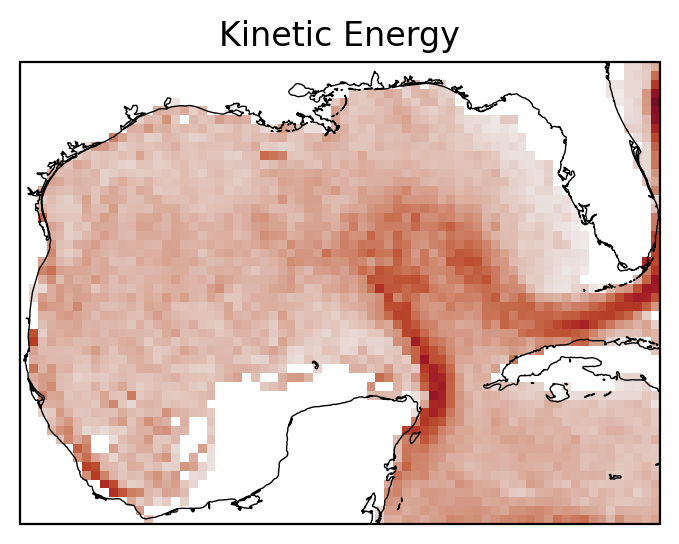

In [19]:
fig = plt.figure(figsize=(8, 3), dpi=200)
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

ax.pcolormesh(
    ds_binned_ke.lon,
    ds_binned_ke.lat,
    ds_binned_ke["ke"].values.T,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.amp,
)


ax.set_title("Kinetic Energy")
ax.coastlines(linewidth=0.5)
ax.set_extent([-98, -80, 18, 31], crs=ccrs.PlateCarree())
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")